## A custom Model
This notebook shows how to implement and train a model other than the baseline used for this challenge.

In [6]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import torch

from utils import creating_dataset
import numpy as np

# Import the config file
import config

### Load data

In [7]:
# DATA_PATH = r"F:\Dropbox (Personal)\BCII\BCI Challenges\2024 ALVI EMG Decoding\dataset_v2_blocks\dataset_v2_blocks"
DATA_PATH = config.DATA_PATH
data_paths = dict(datasets=[DATA_PATH],
                    hand_type = ['left', 'right'], # [left, 'right']
                    human_type = ['health', 'amputant'], # [amputant, 'health']
                    test_dataset_list = ['fedya_tropin_standart_elbow_left'])
data_config = creating_dataset.DataConfig(**data_paths)
train_dataset, test_dataset = creating_dataset.get_datasets(data_config, )

Getting val datasets
Number of moves: 72 | Dataset: fedya_tropin_standart_elbow_left
Reorder this dataset fedya_tropin_standart_elbow_left True
Getting train datasets
Number of moves: 72 | Dataset: fedya_tropin_standart_elbow_left
Reorder this dataset fedya_tropin_standart_elbow_left True
Number of moves: 70 | Dataset: valery_first_standart_elbow_left
Reorder this dataset valery_first_standart_elbow_left True
Number of moves: 135 | Dataset: alex_kovalev_standart_elbow_left
Reorder this dataset alex_kovalev_standart_elbow_left True
Number of moves: 72 | Dataset: anna_makarova_standart_elbow_left
Reorder this dataset anna_makarova_standart_elbow_left True
Number of moves: 62 | Dataset: artem_snailbox_standart_elbow_left
Reorder this dataset artem_snailbox_standart_elbow_left True
Number of moves: 144 | Dataset: matthew_antonov_standart_elbow_left
Reorder this dataset matthew_antonov_standart_elbow_left True
Number of moves: 144 | Dataset: misha_korobok_standart_elbow_left
Reorder this da

## Define model
We define a simple Multi Layer Perceptron, fully connected feedforward neural network with 2 hidden layers. The model is implemented using PyTorch.

In [8]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.layers(x)

Try making a prediction using this model.

In [9]:
X, Y = train_dataset[0]
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

n_inputs, n_outputs = X.shape[0], Y.shape[0]
print(f"Number of inputs: {n_inputs}, number of outputs: {n_outputs}")
n_hidden = 64

model = MLP(n_inputs, n_hidden, n_outputs)


Y_hat = model(torch.tensor(X.T)).detach().numpy().T

print(f"Predictions shape: {Y_hat.shape}") # Predictions shape: (20, 32)

assert Y.shape == Y_hat.shape, "Predictions have the wrong shape!"

X shape: (8, 256), Y shape: (20, 32)
Number of inputs: 8, number of outputs: 20
Predictions shape: (20, 256)


AssertionError: Predictions have the wrong shape!

As you can see. The model's predictions are of the wrong shape: the outputs are not downsampled! Remember that inputs are sampled at 200Hz, but outputs are meant to be at 25Hz. We need to downsample the outputs to match the expected shape.

You can choose your own downsampling method, but make sure that your predictions are aligned to the targets!

In [10]:
import numpy as np

def simple_downsample(x: np.ndarray) -> np.ndarray:
    return x[:, ::data_config.down_sample_target]

Y_hat = model(torch.tensor(X.T)).detach().numpy().T
Y_hat = simple_downsample(Y_hat)


assert Y.shape == Y_hat.shape, "Predictions have the wrong shape!"

For simplicity, you can build the downsampling into your model

In [11]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        x = self.layers(x)
        return x[::data_config.down_sample_target, :]
    

model = MLP(n_inputs, n_hidden, n_outputs)

Y_hat = model(torch.tensor(X.T)).detach().numpy().T
assert Y.shape == Y_hat.shape, "Predictions have the wrong shape!"

In [ ]:
# # this is the implementation of the transfer learning model
# # Doesn't work yet, need to be modified
# import timm
# import lightning as lit

# # class MLP(torch.nn.Module):
# class MLP(lit.LightningModule):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(MLP, self).__init__()

#         self.model = timm.create_model(
#             "resnet34", #model_name,
#             pretrained=True,
#             num_classes=output_size,
#             #drop_rate=drop_out,
#         )


#         self.layers = torch.nn.Sequential(
#             torch.nn.Linear(input_size, hidden_size),
#             torch.nn.ReLU(),
#             torch.nn.Linear(hidden_size, output_size)
#         )

#     def forward(self, x):
#         # x = self.layers(x)
#         x = self.model(x)
#         return x[::data_config.down_sample_target, :]
    

# X, Y = train_dataset[0]
# print(f"X shape: {X.shape}, Y shape: {Y.shape}")

# n_inputs, n_outputs = X.shape[0], Y.shape[0]
# print(f"Number of inputs: {n_inputs}, number of outputs: {n_outputs}")
# n_hidden = 64

# model = MLP(n_inputs, n_hidden, n_outputs)

# Y_hat = model(torch.tensor(X.T)).detach().numpy().T
# assert Y.shape == Y_hat.shape, "Predictions have the wrong shape!"

## Training

We define a very simple training procedure.

In [ ]:
n_epochs = 25
lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(n_inputs, n_hidden, n_outputs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    
    epoch_loss = 0
    for X,Y in train_dataset:
        X, Y = torch.tensor(X.T).to(device), torch.tensor(Y).to(device)
        Y_hat = model(X).T

        loss = criterion(Y_hat, Y)
        loss.backward()
        epoch_loss += loss.item()

        optimizer.step()

    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

    

Epoch 1 Loss: 14360825.3108
Epoch 2 Loss: 2038618848.3921
Epoch 3 Loss: 2183074166.5399
Epoch 4 Loss: 498072217.9761
Epoch 5 Loss: 693923.9264
Epoch 6 Loss: 49018.0170
Epoch 7 Loss: 27124.2872
Epoch 8 Loss: 28227.6572
Epoch 9 Loss: 27684.0696
Epoch 10 Loss: 27660.4545
Epoch 11 Loss: 27459.3165
Epoch 12 Loss: 27090.3863
Epoch 13 Loss: 27158.2085
Epoch 14 Loss: 27606.0665
Epoch 15 Loss: 27229.5720
Epoch 16 Loss: 27344.3499
Epoch 17 Loss: 27473.2908
Epoch 18 Loss: 27277.6425
Epoch 19 Loss: 27296.7149
Epoch 20 Loss: 27057.7852
Epoch 21 Loss: 27705.9931
Epoch 22 Loss: 27075.3975
Epoch 23 Loss: 27572.1392
Epoch 24 Loss: 26912.4114
Epoch 25 Loss: 27070.6836


### Let's plot some predictions

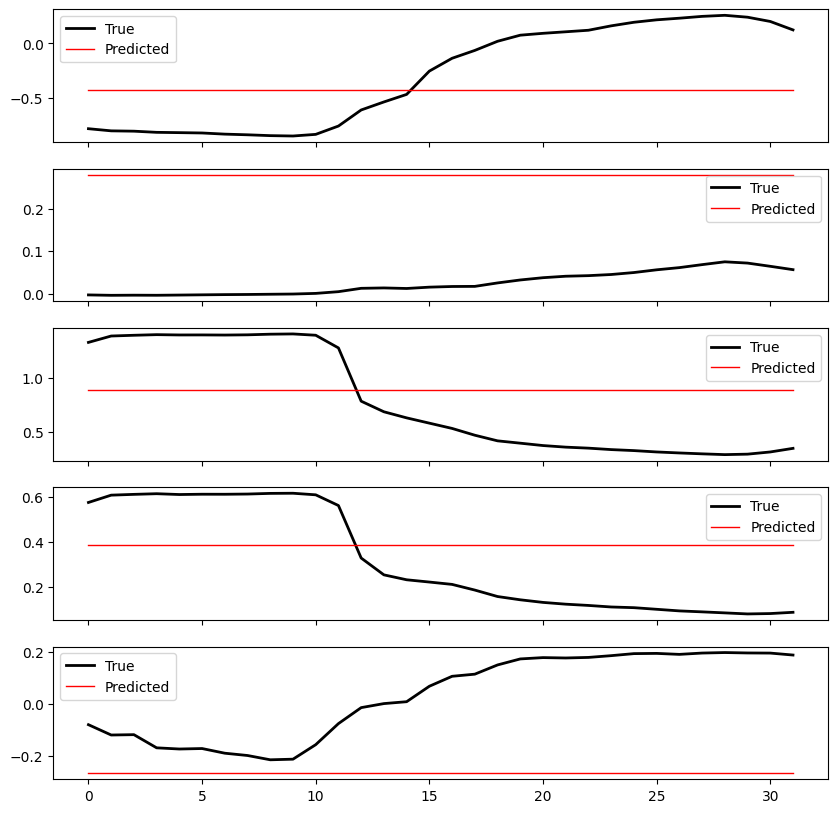

In [ ]:
import matplotlib.pyplot as plt


X, Y = test_dataset[0]

Y_hat = model(torch.tensor(X.T).to(device)).detach().cpu().numpy().T

f, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

for i, ax in enumerate(axes):
    ax.plot(Y[i], label="True", lw=2, color='k')
    ax.plot(Y_hat[i], label="Predicted", lw=1, color='r')

    ax.legend()

# The results are not good, but the model is basically not well trained in this case.